### MTB alignment
#### Usage
MTB(A,B) : Align image B to A

Return (aligned B, offset)

In [1]:
import cv2
import sys 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from einops import rearrange
def shift(img,x,y):
    m = np.float32([[1,0,x],[0,1,y]])
    ret = cv2.warpAffine(img,m,img.shape[:2][::-1])
    return ret

def MTB(A_rgb, B_rgb , value_range = 40 , LEVEL = 4):

    if A_rgb.shape != B_rgb.shape:
        B_rgb = cv2.resize(B_rgb, A_rgb.shape[:2][::-1] )

    A_gray = cv2.cvtColor(A_rgb, cv2.COLOR_BGR2GRAY)

    B_gray = cv2.cvtColor(B_rgb, cv2.COLOR_BGR2GRAY)


    offsets = [[i,j] for i in range(-1,2) for j in range(-1,2)]
    off_x = 0
    off_y = 0 

    for level in range(LEVEL,-1,-1):
        size = (A_gray.shape[1]//(2**level) , A_gray.shape[0]//(2**level))
        A = cv2.resize(A_gray, size)
        B = cv2.resize(B_gray, size)

        med_A = np.median(A)
        ret , thres_A = cv2.threshold(A, med_A, 255, cv2.THRESH_BINARY)
        med_B = np.median(B)
        ret , thres_B = cv2.threshold(B, med_B, 255, cv2.THRESH_BINARY)
        thres_A //=255
        thres_B //=255

        # value_range = 40
        # Tune 
        mask_A	= cv2.inRange(A, med_A - value_range, med_A + value_range)
        mask_B	= cv2.inRange(B, med_B - value_range, med_B + value_range)

        X_best,Y_best = 0,0
        best = np.inf
        for x,y in offsets:
            err = np.sum((thres_A ^ shift(thres_B,x,y)) & mask_A & mask_B)

            if err < best:
                best = err
                X_best,Y_best = x,y
        off_x += X_best * (2 ** level)
        off_y += Y_best * (2 ** level)

    return shift(B_rgb ,off_x,off_y) , (off_x,off_y)

def MTB_cv2(imga,imgb):
    align = cv2.createAlignMTB()
    off = align.calculateShift(cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY),cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY))
    return shift(imgb ,off[0],off[1]) , off

# Robertson method

In [12]:
def opt_e(z, w, t ,g):
    E = np.zeros(z.shape[1])
    Numer = np.zeros(z.shape[1])
    Denom = np.zeros(z.shape[1])
    for j in range(z.shape[0]):
        Numer += w[z[j]] * g[z[j]] * t[j]
        Denom += w[z[j]] * t[j] * t[j]

    E = Numer/(Denom + 1e-10)
    obj = 0
    for j in range(z.shape[0]):
        obj += (w[z[j]] * (g[z[j]] - E*t[j])**2).sum()
    return E,obj


def opt_g(z, w, t ,e , G):

    et = np.outer(t,e)
    Em = np.zeros(256)
    Emsize = np.zeros(256)
    np.add.at(Em ,z.round() ,et)
    np.add.at(Emsize ,z.round() ,1)

    G[Emsize > 0] = (Em/(Emsize+1e-10))[Emsize > 0]
    G[Emsize > 0] /=G[128] + 1e-10
    return G 


def robertson(z , t , w ,iter ,thres=0.01 ,lr = 1):
  # z:(photo_num , h , w)
  
    z =  np.array(z)
    z_flat = rearrange(z,'L h w c -> c L (h w)')
    E,G=[],[]

    for rgb in tqdm([0,1,2]):

        g = np.arange(256,dtype='float32')/128
        e = np.random.randn(z_flat.shape[2])

        obj_prev = 0
        for it in range(iter):
            prev_e , prev_g = e.copy(),g.copy()
            
            ee , obj_cur = opt_e(z_flat[rgb] , w, t , g.copy())
            e = e*(1-lr) + lr*ee
            
            gg = opt_g(z_flat[rgb] , w, t , e.copy() , g.copy())
            g = g*(1-lr) + lr*gg
            
            
            if it!= 0 and abs(obj_prev-obj_cur) < thres:
                print('end',it ,obj_prev-obj_cur)
                break
            obj_prev=obj_cur
        G.append(g)
        E.append(e)
    E = rearrange(np.array(E),'c (h w) ->h w c',h = z.shape[1])
    return E,G

[]

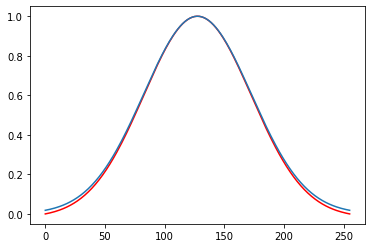

In [3]:
def RobertsonWeights():
    q = 255 / 4.0;
    e4 = np.exp(4.);
    scale = e4/(e4 - 1.);
    shift = 1 / (1. - e4);
    i = np.arange(0,256)
    v = (i/q - 2)
    w = scale*np.exp(-v * v) + shift;
    return w
def RobertsonWeights1():
    return np.exp( -4* ((np.arange(0,256)-127.5)**2) / (127.5**2) )

plt.plot(RobertsonWeights(),color='red')
plt.plot(RobertsonWeights1())
plt.plot()

# Tone mapping funciton
No implement, use opencv

In [4]:
def tone(hdr_img , light = 1.5 ,**args ):
    tm = cv2.createTonemapReinhard(light ,**args)
    return np.clip(tm.process(hdr_img.astype(np.float32))*255, 0, 255).astype('uint8')
def tone2(hdr_img , **args ):
    tm = cv2.createTonemapMantiuk(gamma = 1,scale = 0.5, saturation = 1.0)
    return np.clip(tm.process(hdr_img.astype(np.float32))*255, 0, 255).astype('uint8')
def tone3(hdr_img , **args ):
    tm = cv2.createTonemap(gamma = 2.2,**args)
    return np.clip(tm.process(hdr_img.astype(np.float32))*255, 0, 255).astype('uint8')

In [5]:
def gaussian_blurs(im, smax=25, a=1.0, fi=8.0, epsilon=0.01 , **args):
#     print(smax)
    cols, rows = im.shape
    blur_prev = im
    num_s = int((smax+1)/2)
    
    blur_list = np.zeros(im.shape + (num_s,))
    Vs_list = np.zeros(im.shape + (num_s,))
    
    for i, s in enumerate(range(1, smax+1, 2)):

        blur = cv2.GaussianBlur(im, (s, s), 0)
        Vs = np.abs((blur - blur_prev) / (2 ** fi * a / s ** 2 + blur_prev))
        blur_list[:, :, i] = blur
        Vs_list[:, :, i] = Vs
    

    smax = np.argmax(Vs_list > epsilon, axis=2)
    smax[np.where(smax == 0)] = 1
    smax -= 1

    I, J = np.ogrid[:cols, :rows]
    blur_smax = blur_list[I, J, smax]

    return blur_smax

def photographic_local(radiance, d=1e-9, a=0.5, method=0 ,glob = 0 , **args):
    result = np.zeros_like(radiance, dtype=np.float32)
    weights = [0.065, 0.67, 0.265]
    
    if method == 0:
        Lw_ave = np.exp(np.mean(np.log(d + radiance)))
        
        for c in range(3):
            Lw = radiance[:, :, c]
            Lm = (a / Lw_ave) * Lw
            Ls = gaussian_blurs(Lm , **args)
            Ld = Lm / (1 + Ls*(1-glob) + Lm*glob)
            result[:, :, c] = np.clip(np.array(Ld * 255), 0, 255).astype(np.uint8)
    
    elif method == 1:
        Lw = 0.065 * radiance[:, :, 0] + 0.67 * radiance[:, :, 1] + 0.265 * radiance[:, :, 2]
        Lw_ave = np.exp(np.mean(np.log(d + Lw)))
        Lm = (a / Lw_ave) * Lw
        Ls = gaussian_blurs(Lm , **args)
        Ld = Lm / (1 +  Ls*(1-glob) + Lm*glob)
        
        for c in range(3):
            result[:, :, c] = np.clip(np.array((Ld / Lw) * radiance[:, :, c] * 255), 0, 255).astype(np.uint8)

    return result

#### Get images and exposure time function


In [6]:
import os
import PIL.Image
from PIL.ExifTags import TAGS
from pprint import pprint
import rawpy

PATH = '/tmp2/100CANON/3/JPG/'
PATHRAW = '/tmp2/100CANON/3/RAW/'
def getimgs(PATH = PATH):
    imgs = []
    expo_time = []
    for f in sorted(os.listdir(PATH)):
        image = PIL.Image.open(PATH + f)
        exif_data = {
                    PIL.ExifTags.TAGS[k]: v
                    for k,v in image._getexif().items()
                    if k in PIL.ExifTags.TAGS
                }
    
        print(f ,exif_data['ExposureTime'])
        imgs.append(cv2.imread(PATH+f))
        expo_time.append(exif_data['ExposureTime'])
    return imgs,expo_time

def getRAWs(PATH = PATHRAW):
    imgs = []
    expo_time = []
    for f in sorted(os.listdir(PATH)):
        raw = rawpy.imread(PATH+f)
        bayer = raw.postprocess()
        print(f)
        imgs.append(bayer)
    return imgs

### Usage : set PATH

In [63]:

folder = 1
PATH = f'/tmp2/100CANON/{folder}/JPG/'

imgs  , expotime = getimgs(PATH  = PATH )
hdrs=[]
expotime = np.array(expotime).astype('float32')

HasRAW = False

if HasRAW:
    PATHRAW = f'/tmp2/100CANON/{folder}/RAW/'
    RAWS = getRAWs( PATH  = PATHRAW)
    print(len(RAWS))

IMG_0106.JPG 0.000625
IMG_0107.JPG 0.000625
IMG_0108.JPG 0.0008
IMG_0109.JPG 0.001
IMG_0110.JPG 0.0015625
IMG_0111.JPG 0.003125
IMG_0112.JPG 0.005
IMG_0113.JPG 0.01
IMG_0114.JPG 0.025
IMG_0115.JPG 0.03333333333333333
IMG_0116.JPG 0.06666666666666667
IMG_0117.JPG 0.125


### Produce Radiance map

(0, 0)
(0, 0)
(0, 0)
(0, -1)
(0, 0)
(0, -1)
(0, -3)


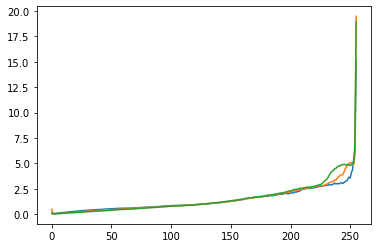

In [64]:
   
res=2
resize = 1
align = 1
img = imgs.copy()

# Select good photos range
st = 2
end = -2
t = img.copy()[st:end]
if HasRAW:
    R = RAWS.copy()[st:end]
expo = expotime.copy()[st:end]

if resize == True:
    for i in range(len(t)):
        t[i] = cv2.resize(t[i],(t[i].shape[1]//res,t[i].shape[0]//res))
        if HasRAW:
            R[i] = cv2.resize(R[i],(R[i].shape[1]//res,R[i].shape[0]//res))

if align == True:
    for i in range(1,len(t)):
        t[i] , offset= MTB(t[0],t[i],value_range=20,LEVEL=1)

        print(offset)

w = RobertsonWeights()
# hdr , g = robertson(t,expo, w,10 ,thres=0.1, lr = 1)  
cal_robertson = cv2.createCalibrateRobertson(max_iter=10, threshold=0.1)
merge_robertson = cv2.createMergeRobertson()
crf_robertson = cal_robertson.process(t, times=expo)
hdr = merge_robertson.process(t, times=expo, response=crf_robertson.copy())

if HasRAW:
    hdr_RAW = (R / expo[:,None,None,None]).mean(axis=0).astype('float32')

for gg in g:
    plt.plot(gg)
plt.show()
#PLot response curve





In [65]:
cv2.imwrite(f'result.hdr',hdr)

True

### Tone mapping

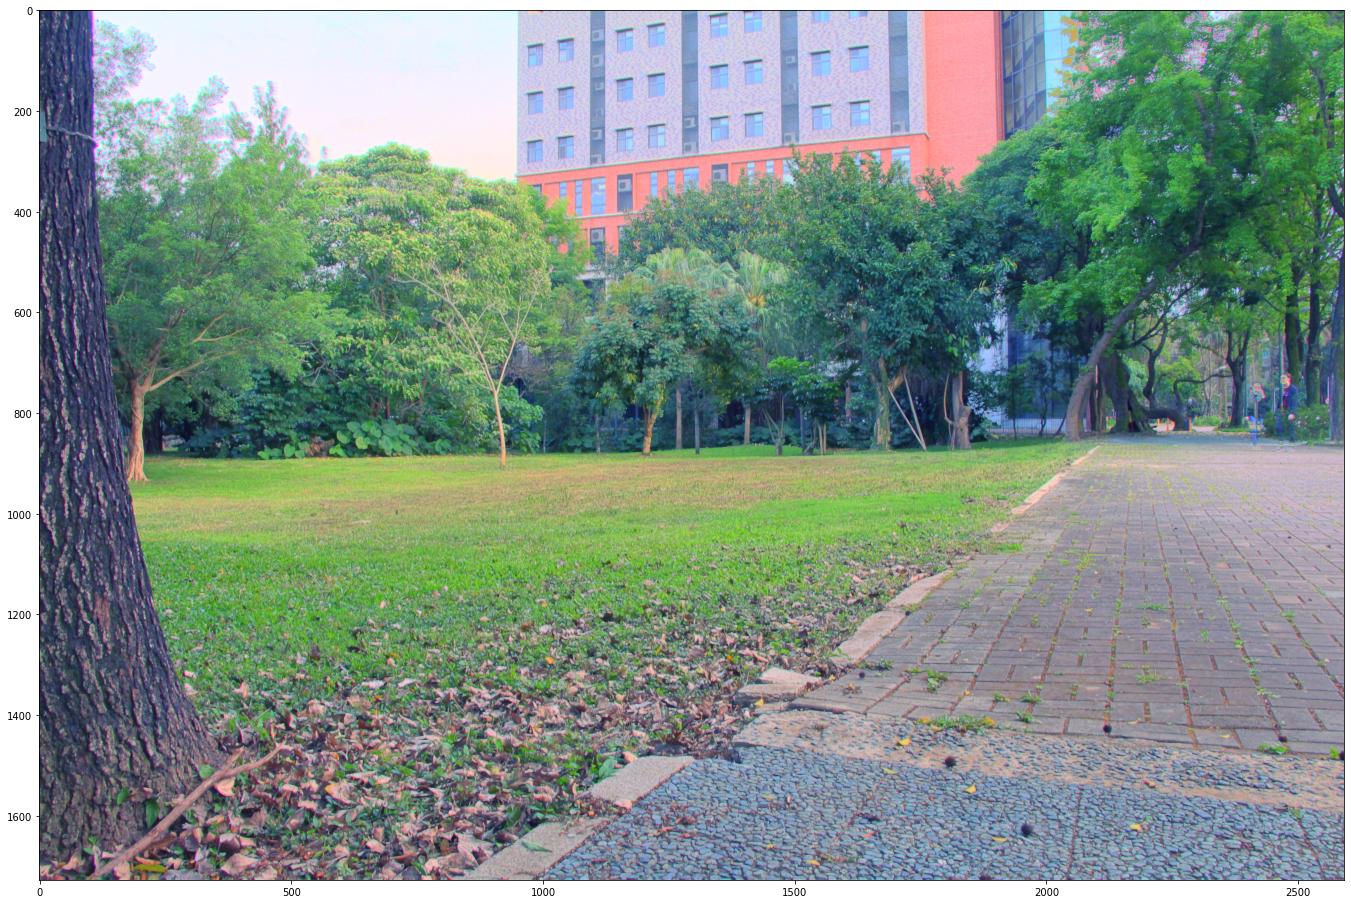

True

In [66]:
radiance_map = hdr
# radiance_map = hdr_RAW

tm = photographic_local(radiance_map ,method = 1 , a = 1.2).astype(np.uint8)
tm = cv2.cvtColor(tm, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(36,16))
plt.imshow(tm)
plt.show()

cv2.imwrite(f'result.png',cv2.cvtColor(tm, cv2.COLOR_RGB2BGR))
